This is a demonstration of the features of IJuliaTimeMachine. It also explains some of the design choices.

# What IJulia Provides

IJulia already provides some historical information. `In` records the inputs to cells, and `Out` records their outputs.  `IJulia.n` is the number of the current cell.

In [1]:
1+1

2

In [2]:
In[1]

"1+1"

In [3]:
Out[1]

2

# Setting up IJuliaTimeMachine

I recommend assigning `IJuliaTimeMachine` a shorter name, like `TM` as below.

In [4]:
import IJuliaTimeMachine
TM = IJuliaTimeMachine

IJuliaTimeMachine

If you use it a lot, and don't want to keep typing the `TM` prefix, you can instead type `using IJuliaTimeMachine`.
This will import `@past` and `vars`.

# Recalling past states

In [5]:
x = 1+1

2

In [6]:
x = randn(3)

3-element Array{Float64,1}:
 -0.07656817141946694
 -1.7219397904552953
 -1.6390299328866278

Say that I just accidentally change the value of the variable `x`, and I'd like to know what it's value was after cell 5.  I can recover the state of variables from then with `@past`.

In [7]:
TM.@past 5
x

2

The value of `ans` was also recalled.

In [8]:
ans

2

The Time Machine stores a `deepcopy` of every variable.  While this is inefficient, it allows us to recover a vector, even if some other cell changes one of its entries.

In [9]:
vec = collect(1:4)

4-element Array{Int64,1}:
 1
 2
 3
 4

In [10]:
vec[3] = 100
vec

4-element Array{Int64,1}:
   1
   2
 100
   4

In [11]:
TM.@past 9
vec

4-element Array{Int64,1}:
 1
 2
 3
 4

By default `@past` also recalls the output of the past cell, and so that output appears in the display.

In [12]:
TM.@past 9

4-element Array{Int64,1}:
 1
 2
 3
 4

This can be very useful because IJulia's Out stores a pointer to an array, rather than the array.
This means that the value recalled can be changed, like this.

In [13]:
y = [1;2;3]

3-element Array{Int64,1}:
 1
 2
 3

In [14]:
Out[13]

3-element Array{Int64,1}:
 1
 2
 3

In [15]:
y[3] = 0
Out[13]

3-element Array{Int64,1}:
 1
 2
 0

Note that the last element changed to a 0. This does not happen with the values stored by the Time Machine.

In [16]:
TM.@past 13

3-element Array{Int64,1}:
 1
 2
 3

The Time Machine only stores variables it can effectively copy.
Right now, it can not copy functions.  

In [17]:
# note that cell is equal to the number of this cell, 17.
cell = IJulia.n
f(x) = x
f(1)

1

In [18]:
y = 2
f(x) = 2x
f(1)

2

In [19]:
TM.@past cell

1

In [20]:
f(1)

2

But, if the only thing that changes in a function is a global variable, then you can essentially recover the function.

In [21]:
f(x) = y*x

f (generic function with 1 method)

In [22]:
cell = IJulia.n
y = 3
f(1)

3

In [23]:
y = 4
f(1)

4

In [24]:
TM.@past cell

3

In [25]:
f(1)

3

You can stop the Time Machine from saving.

In [26]:
TM.saving!(false)

save_state (generic function with 1 method)

In [27]:
z = "hello!"

"hello!"

In [28]:
TM.@past 27

LoadError: State 27 was not saved.

And, you can make it start saving again.

In [29]:
TM.saving!(true)

1-element Array{Function,1}:
 save_state (generic function with 1 method)

In [30]:
z = "hi :)"

"hi :)"

In [31]:
z = "overwrite that"

"overwrite that"

In [32]:
TM.@past 30
z

"hi :)"

If we really want to forget the past, or just save memory, we can clear some history.  Just give a list of the cells to be cleared.  If no list is specified, it clears all of them. This is the safest option, because to free up the memory used by a variable, one must clear *every* cell in which that variable exists.

In [33]:
z = []
TM.clear_past([30])

In [34]:
TM.@past 30

LoadError: State 30 was not saved.

But, this didn't get rid of the string "hi :)", because that string was also saved in cell 32.
You can see that by using the `vars` function, which returns a dictionary of all the variables saved with a cell.
To get rid of that string, we would need to clear cells 30 and 32.

In [35]:
TM.vars(32)

Dict{Any,Any} with 5 entries:
  :vec  => [1, 2, 3, 4]
  :y    => 3
  :cell => 22
  :z    => "hi :)"
  :x    => 2

The big table of all the stored variables is `TM.VX.store`

In [36]:
TM.VX.store

Dict{Any,Any} with 14 entries:
  0xf02d7561089106d2 => [1, 2, 3, 4]
  0xc70ed234e0a3ad59 => 17
  0xf15becc4be4c0cd4 => [-0.0765682, -1.72194, -1.63903]
  0xf4e13e0713120297 => "hi :)"
  0x3688cf5d48899fa6 => 3
  0x5c97e8eedebac7cc => [1, 2, 100, 4]
  0x5a94851fb48a6e05 => 2
  0x40322bb383bc0a9c => [1, 2, 3]
  0x867b4bb4c42e5661 => 4
  0xf9dae1a92b5e5ba7 => Any[]
  0x6fd433390b9283dd => 22
  0xb98a8ec9a0959679 => "hello!"
  0x700bc5643854405f => "overwrite that"
  0x6680a11d7499012b => [1, 2, 0]

In [37]:
z = []
TM.clear_past(30:36)

In [38]:
TM.VX.store

Dict{Any,Any} with 12 entries:
  0xf02d7561089106d2 => [1, 2, 3, 4]
  0xc70ed234e0a3ad59 => 17
  0xf15becc4be4c0cd4 => [-0.0765682, -1.72194, -1.63903]
  0x3688cf5d48899fa6 => 3
  0x5c97e8eedebac7cc => [1, 2, 100, 4]
  0x5a94851fb48a6e05 => 2
  0x40322bb383bc0a9c => [1, 2, 3]
  0x867b4bb4c42e5661 => 4
  0xf9dae1a92b5e5ba7 => Any[]
  0x6fd433390b9283dd => 22
  0xb98a8ec9a0959679 => "hello!"
  0x6680a11d7499012b => [1, 2, 0]

If you want to see the cell output that TM stored,look at `TM.ans(cell)`.

In [39]:
TM.ans(23)

4

Variables are stored by hash so that each piece of data is only stored once. This reduces wasted memory.
Unfortunately, we can not use Julia's default hash function to do this, as small changes to data do not necessarily change this hash. Here are two examples of this problem.

In [40]:
a = randn(1000,1000)
h0 = hash(a)
a[1,1] = 0
h1 = hash(a)
h0 == h1

true

In [41]:
mutable struct S
    a
end
x = S(1)
h0 = hash(x)
x.a = 0
h1 = hash(x)
h0 == h1

true

TM uses its own hash function to avoid this problem.

In [42]:
a = randn(1000,1000)
h0 = TM.tm_hash(a)
a[1,1] = 0
h1 = TM.tm_hash(a)
h0 == h1

false

In [43]:
mutable struct S
    a
end
x = S(1)
h0 = TM.tm_hash(x)
x.a = 0
h1 = TM.tm_hash(x)
h0 == h1

false

Unfortunately, tm_hash is can be slow because it must examine every element of a data structure.
But, you probably don't want to store a big chunk of data in the TM anyway.

If you have some big piece of data that you do not want stored, you can tell the Time Machine not to do that.
The function `dontsave` tells the TM not to store the variable it is given.
But, if you copy the variable, the copy will be saved.
Similarly, it will be saved if you bind the variable to a new piece of data.

In [44]:
BIG = randn(1000,1000)
TM.dontsave(BIG)

In [45]:
TM.vars(IJulia.n - 1)

Dict{Any,Any} with 9 entries:
  :a    => [0.0 0.580431 … 0.0275737 -0.607591; 1.60128 0.293623 … 0.177615 -0.…
  :vec  => [1, 2, 3, 4]
  :h1   => 0x4330888b40615b85
  :y    => 3
  :h0   => 0xc0fb5ae483d856da
  :cell => 22
  :S    => S
  :z    => Any[]
  :x    => S(0)

In [46]:
Y = BIG
Y === BIG

true

In [47]:
# Y is not saved because it has the same binding as BIG
TM.vars(IJulia.n - 1)

Dict{Any,Any} with 9 entries:
  :a    => [0.0 0.580431 … 0.0275737 -0.607591; 1.60128 0.293623 … 0.177615 -0.…
  :vec  => [1, 2, 3, 4]
  :h1   => 0x4330888b40615b85
  :y    => 3
  :h0   => 0xc0fb5ae483d856da
  :cell => 22
  :S    => S
  :z    => Any[]
  :x    => S(0)

In [48]:
# now, Y has a different binding
Y = copy(BIG)
Y === BIG, Y == BIG

(false, true)

In [49]:
TM.vars(IJulia.n - 1)

Dict{Any,Any} with 10 entries:
  :a    => [0.0 0.580431 … 0.0275737 -0.607591; 1.60128 0.293623 … 0.177615 -0.…
  :vec  => [1, 2, 3, 4]
  :h1   => 0x4330888b40615b85
  :y    => 3
  :h0   => 0xc0fb5ae483d856da
  :cell => 22
  :S    => S
  :Y    => [-1.23786 0.744897 … -1.28247 0.0257696; 0.585993 -1.45679 … -0.5606…
  :z    => Any[]
  :x    => S(0)

In [50]:
# This does not change the binding of BIG
BIG[1,1] = 0

0

In [51]:
TM.vars(IJulia.n - 1)

Dict{Any,Any} with 10 entries:
  :a    => [0.0 0.580431 … 0.0275737 -0.607591; 1.60128 0.293623 … 0.177615 -0.…
  :vec  => [1, 2, 3, 4]
  :h1   => 0x4330888b40615b85
  :y    => 3
  :h0   => 0xc0fb5ae483d856da
  :cell => 22
  :S    => S
  :Y    => [-1.23786 0.744897 … -1.28247 0.0257696; 0.585993 -1.45679 … -0.5606…
  :z    => Any[]
  :x    => S(0)

On this laptop, it takes about half a second to hash an 800MB array. If Jupyter is reacting slowly, hashing a big variable could be the reason. You can fix this by telling Jupyter to stop saving it. But, you won't loose it.

In [52]:
@time BIG = randn(1000,1000,100)
@show Base.summarysize(BIG)
@time TM.tm_hash(BIG)

  0.623984 seconds (2 allocations: 762.940 MiB, 8.07% gc time)
Base.summarysize(BIG) = 800000048
  0.488059 seconds (67.17 k allocations: 3.211 MiB)


0xc1ba4cc9ec75c856

In [53]:
TM.dontsave(Y)

In [54]:
# But, we changed the binding of BIG. So it has been saved.
TM.vars(IJulia.n - 1)

Dict{Any,Any} with 10 entries:
  :a    => [0.0 0.580431 … 0.0275737 -0.607591; 1.60128 0.293623 … 0.177615 -0.…
  :vec  => [1, 2, 3, 4]
  :h1   => 0x4330888b40615b85
  :y    => 3
  :h0   => 0xc0fb5ae483d856da
  :cell => 22
  :S    => S
  :z    => Any[]
  :BIG  => [-0.924035 1.59391 … -0.304681 -0.992116; -0.208401 -0.829228 … -1.2…
  :x    => S(0)

`IJulia.n` stores the number of a cell. We will keep using this to index cells to facilitate editing of the notebook.

In [55]:
IJulia.n

55

It even works with plots.

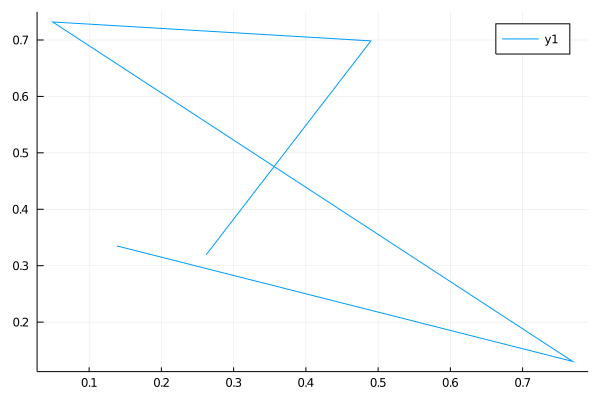

In [56]:
cell = IJulia.n
using Plots
default(fmt = :png)
p = plot(rand(5), rand(5))

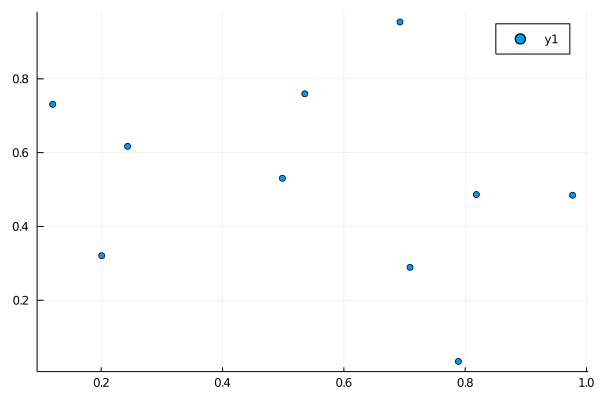

In [57]:
p = scatter(rand(10), rand(10))

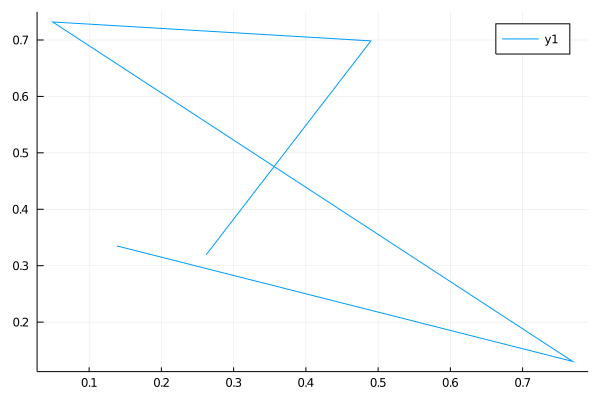

In [58]:
TM.vars(cell)[:p]

# Running big jobs in threads

The other feature of Time Machine is that it lets you run intensive jobs in threads, so that you can get other work done while they are running.  If you have a multicore machine, you can also view this as a way to manage running a bunch of experiments from Jupyter.  The key is to wrap the jobs in `TM.@thread begin`, followed by `end`.  Jobs that are running inside a `@thread` block sandbox their variables. To access the values of the variables from the thread after it finishes, look at `vars`, `ans`, or use `@past`.

When the jobs finish, their result is stored in `Out`, and you can access their state from `past`.
Unfortunately, if the jobs contain any print statements, they can show up in other cells.

To see which jobs are running, look at `TM.running`.  `TM.finished` contains a list of those that have finished.

In the examples below, we will simulate the delay of a long-running job with `sleep`.  As you will see, results will change after jobs finish.

In [59]:
x = collect(1:3)
y = 1

1

In [60]:
t0 = time()
n = IJulia.n
TM.@thread begin
    y = y + 1
    push!(x,y)
    sleep(5)
    sum(x)
end

Task (runnable) @0x00000001192add50

In [61]:
println("After $(time() - t0) seconds.")
Out[n]

After 0.9098551273345947 seconds.


Task (runnable) @0x00000001192add50

In [62]:
sleep(10)

In [63]:
println("After $(time() - t0) seconds.")
Out[n]

After 12.024251937866211 seconds.


8

In [64]:
x, y

([1, 2, 3], 1)

In [65]:
TM.@past n
x, y

([1, 2, 3, 2], 2)

There is a subtle reason that I put the `sleep(10)` statement on a separate line.
The output of finished jobs is only inserted into `Out` at the start of the execution of the first cell that is run after the job finishes. So, it is possible to go one cell without the output being correct.
If you want to test it, put the `sleep(10)`  inside the next cell, and then run the cells in quick succession.

You can not put two `@thread` statements into one cell.

In [66]:
n = IJulia.n
TM.@thread begin
    x = x + 1
    y[1] = 3
    sum(y)
end
TM.@thread begin
    x = x + 1
    y[1] = 4
    sum(y)
end

@thread can be called at most once per cell.


But, you can have many running at once.  That's the point!

In [67]:
function intense(n)
    sleep(n)
    println("I slept for $(n) seconds!")
    n^2
end

intense (generic function with 1 method)

In [68]:
t0 = time()
n1 = IJulia.n
TM.@thread intense(10)

Task (runnable) @0x00000001192ad690

In [69]:
println("After $(time()-t0) seconds")
n2 = IJulia.n
TM.@thread intense(11)

After 0.508124828338623 seconds


Task (runnable) @0x000000011845f190

In [70]:
println("After $(time()-t0) seconds")
n3 = IJulia.n
TM.@thread intense(2)

After 1.018509864807129 seconds


Task (runnable) @0x00000001192ae890

In [71]:
println("After $(time()-t0) seconds")
TM.running

After 1.5418009757995605 seconds


Set{Any} with 3 elements:
  68
  69
  70

In [72]:
sleep(3)

I slept for 2 seconds!


In [73]:
println("After $(time()-t0) seconds")
TM.running

After 6.071583032608032 seconds


Set{Any} with 2 elements:
  68
  69

In [74]:
println("After $(time()-t0) seconds")
TM.finished

After 6.620029926300049 seconds


2-element Array{Int64,1}:
 60
 70

In [75]:
sleep(10)
println("After $(time()-t0) seconds")
TM.running

I slept for 10 seconds!
I slept for 11 seconds!
After 17.50132989883423 seconds


Set{Any}()

In [76]:
Out[n1], Out[n2], Out[n3]

(100, 121, 4)

You can also get notifications of when jobs finish.
These can be sent to Jupyter, in which case they will just print.
You can also send them to the terminal in which Jupyter is running, or both.

In [77]:
TM.notify_jupyter!(true)
TM.notify_terminal!(true)
@TM.thread begin
    println("this will run for 3 seconds")
    sleep(3)
end

this will run for 3 seconds


Task (runnable) @0x000000011845c010

In [78]:
n = IJulia.n
using LinearAlgebra
@TM.thread begin
    min_svd = Inf
    min_matrix = []
    for i in 1:100
        M = rand([-1;1], 1000, 1000)
        v = minimum(svdvals(M))
        if v < min_svd
            min_svd = v
            min_matrix = M
        end
    end
    min_svd
end

Cell 78

Task (runnable) @0x00000001188be890

 finished.
Cell 77 finished.


In [79]:
# do some other stuff, clobbering v and M
v = 0
M = randn(100,100)
;

In [80]:
# that min svd value computed above
TM.ans(n)

0.00012619151374331338

In [81]:
# and, the matrix that realized it
M = TM.vars(n)[:min_matrix]
minimum(svdvals(M))

0.00012619151374331338